<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Classification Model Analysis for Marvel vs DC reddit

## Part 2 of 4: Data Cleaning and Exploring Data Analysis (EDA) of scrapped data
---
Part 1: Scrapping of the data from reddit into csv files

Part 2: Data Cleaning and Exploring Data Analysis (EDA) of scrapped data

Part 3:  Hyperparameter tuning and feature engineering after model evaluation and sentiment analysis.

# Define Libraries
---

In [1]:
import requests
import datetime
import json
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
import emoji
import demoji
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import seaborn as sns
from pmaw import PushshiftAPI

### Print out full data
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.options.display.max_colwidth = 150

import warnings
warnings.filterwarnings("ignore")

# Import dataset
---

In [2]:
ms_df = pd.read_csv("./datasets/marvel_full.csv")

In [3]:
dc_df = pd.read_csv("./datasets/dc_full.csv")

In [4]:
print(dc_df.shape)
dc_df.head()

(10097, 85)


,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_is_blocked,author_patreon_flair,author_premium,awarders,can_mod_post,contest_mode,created_utc,domain,full_link,gildings,id,is_created_from_ads_ui,is_crosspostable,is_meta,is_original_content,is_reddit_media_domain,is_robot_indexable,is_self,is_video,link_flair_background_color,link_flair_css_class,link_flair_richtext,link_flair_template_id,link_flair_text,link_flair_text_color,link_flair_type,locked,media_only,no_follow,num_comments,num_crossposts,over_18,parent_whitelist_status,permalink,pinned,post_hint,preview,pwls,retrieved_on,score,selftext,send_replies,spoiler,stickied,subreddit,subreddit_id,subreddit_subscribers,subreddit_type,thumbnail,thumbnail_height,thumbnail_width,title,total_awards_received,treatment_tags,upvote_ratio,url,url_overridden_by_dest,whitelist_status,wls,gallery_data,is_gallery,media_metadata,removed_by_category,author_flair_background_color,author_flair_text_color,crosspost_parent,crosspost_parent_list,media,media_embed,secure_media,secure_media_embed,author_cakeday,poll_data,distinguished,banned_by,call_to_action,category
0,[],False,josiahcruz__,NaN,[],NaN,text,t2_8jvrb3wk,False,False,False,[],False,False,1656295725,i.redd.it,https://www.reddit.com/r/DC_Cinematic/comments/vlkea2/interesting/,{},vlkea2,False,True,False,False,True,True,False,False,#373c3f,other,[],f75bc422-5d95-11e5-8b12-0eb476717d59,OTHER,light,text,False,False,True,0,0,False,all_ads,/r/DC_Cinematic/comments/vlkea2/interesting/,False,image,"{'enabled': True, 'images': [{'id': '1vuEh1wewfZlUQe1nAk3hDAW8Bg1f2OQVJkRNDRhgWA', 'resolutions': [{'height': 145, 'url': 'https://preview.redd.it...",6,1656295735,1,NaN,False,False,False,DC_Cinematic,t5_2ykm6,329818,public,https://b.thumbs.redditmedia.com/KeL6RXzNhxTPmUh_yyT3yH9iDclNb7RGNItGmEz-WZw.jpg,140.0,140.0,Interesting,0,[],1.0,https://i.redd.it/rv5kf0bk54891.jpg,https://i.redd.it/rv5kf0bk54891.jpg,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],False,jbgDCfan,NaN,[],NaN,text,t2_1441nz,False,False,False,[],False,False,1656294538,i.redd.it,https://www.reddit.com/r/DC_Cinematic/comments/vlk0ld/my_justice_league_lego_set_up_at_my_apartment/,{},vlk0ld,False,True,False,False,True,True,False,False,#cc5289,fanmade,[],c6d7bab0-5edd-11e5-a17a-1290900dce7f,FAN-MADE,light,text,False,False,True,0,0,False,all_ads,/r/DC_Cinematic/comments/vlk0ld/my_justice_league_lego_set_up_at_my_apartment/,False,image,"{'enabled': True, 'images': [{'id': 'o18UuDwh9thb72C2JP1WB0yfd3aWKSVpPJBHCCJItgY', 'resolutions': [{'height': 58, 'url': 'https://preview.redd.it/...",6,1656294548,1,NaN,True,False,False,DC_Cinematic,t5_2ykm6,329810,public,https://b.thumbs.redditmedia.com/YbRftEIgLL1Ln9DtSi-w_JIvnJ5o8b9yIRg0aBUHb9k.jpg,75.0,140.0,My Justice League Lego set up at my apartment - (mostly done but may add things over time so open to suggestions),0,[],1.0,https://i.redd.it/9httnpeik2891.jpg,https://i.redd.it/9httnpeik2891.jpg,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[],False,Bjkrillsz,NaN,[],NaN,text,t2_6lnlksr2,False,False,False,[],False,False,1656292651,reddit.com,https://www.reddit.com/r/DC_Cinematic/comments/vljf6a/so_turns_out_ezra_grooming_or_kidnapping/,{},vljf6a,False,True,False,False,False,True,False,False,#ea0027,news,[],ff1bbabe-5d95-11e5-8d28-0ead67bd777b,NEWS,light,text,False,False,True,0,0,False,all_ads,/r/DC_Cinematic/comments/vljf6a/so_turns_out_ezra_grooming_or_kidnapping/,False,NaN,NaN,6,1656292661,1,NaN,True,False,False,DC_Cinematic,t5_2ykm6,329802,public,https://b.thumbs.redditmedia.com/EsORNF1lXwR1vit3klIGu1tDrsutmmr5-bewY1mBXlg.jpg,140.0,140.0,So turns out Ezra grooming or kidnapping allegations were false.,0,[],1.0,https://www.reddit.com/gallery/vljf6a,https://www.reddit.com/gallery/vljf6a,all_ads,6,"{'items': [{'id': 157263729, 'media_id': '18m1nhcwe2891'}, {'id': 157263730, 'med

# Preliminary Exploratory Data Analysis (EDA)
---

## Determine the dataset for media within the reddit post

From the documentation, the is_sef column can be used to determine if the post contains external links and can be considered. When is_self is true, the post can be considered as a text post. 
[source](https://www.reddit.com/r/help/comments/16secs/what_is_a_self_post/)

In [5]:
ms_df['is_self'].value_counts()

False    5409
True     4684
Name: is_self, dtype: int64

In [6]:
dc_df['is_self'].value_counts()

False    7113
True     2984
Name: is_self, dtype: int64

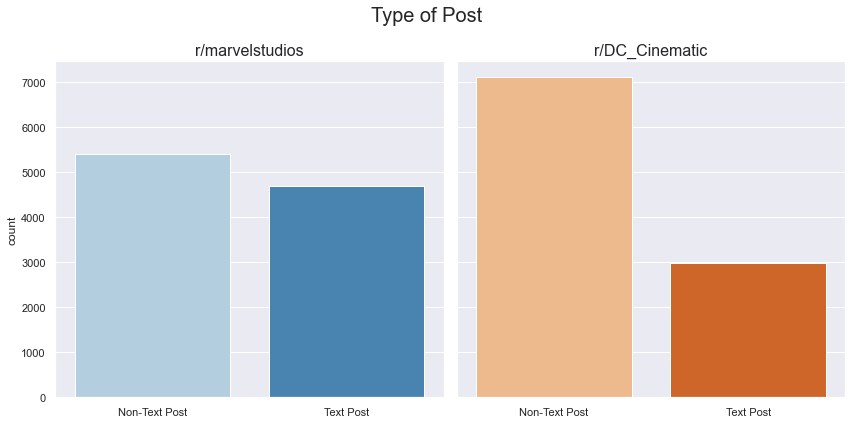

In [317]:
fig, ax = plt.subplots(1, 2, figsize=(12,6), sharey=True)
ax = ax.ravel()
ms1 = sns.countplot(data=ms_df, x=ms_df['is_self'].astype(int), ax = ax[0], palette='Blues')
ms1.set_xticklabels(['Non-Text Post', 'Text Post'])
ms1.set_title('r/marvelstudios', fontsize=16)
ms1.set_xlabel('')
dc2 = sns.countplot(data=dc_df, x=dc_df['is_self'].astype(int), ax = ax[1], palette='Oranges')
dc2.set_xticklabels(['Non-Text Post', 'Text Post'])
dc2.set_title('r/DC_Cinematic', fontsize=16)
dc2.set_ylabel('')
dc2.set_xlabel('')
plt.suptitle('Type of Post', fontsize=20)
plt.tight_layout()

From the plot above, there is a significant amount of non-text post for both the sub-reddits (r/MarvelStudios & r/DC_Cinematic). To retain the information of the two subreddits, both the (**title**) and (**selftext**) is combined and input into a (**post**) column in subsequent data.

## Length of post and title

### Checking the length of the title

In [30]:
#marvel_text ={}
marvel_text['title'] = ms_df['title'].str.len()
marvel_text
#marvel_text = pd.DataFrame(data=ms_df, columns='title')

{'title': 0         85
 1        112
 2         44
 3         16
 4        112
         ... 
 10088     21
 10089     97
 10090     27
 10091     63
 10092     74
 Name: title, Length: 10093, dtype: int64}

In [319]:
def subplot_histograms(data_1, data_2, col, plot_title):
    fig, ax = plt.subplots(1, 2, figsize=(20,10), sharey=True)
    ax = ax.ravel()
    
    # Plot first df   
    g1 = sns.histplot(data=data_1, x=data_1[col].str.len(), ax = ax[0])
    mean_1 = data_1[col].str.len().mean()
    ax[0].axvline(mean_1, ls='-.', color='black')
    g1.set_title(f'r/marvelstudios (Mean: {round(mean_1)} words)')
    g1.set_xlabel(f'Length of {col.capitalize()}')
    
    # Plot second df
    g2 = sns.histplot(data=data_2, x=data_2[col].str.len(), ax = ax[1], color='darkorange')
    mean_2 = data_2[col].str.len().mean()
    ax[1].axvline(mean_2, ls='-.', color='black')
    g2.set_title(f'r/DC_Cinnematic (Mean: {round(mean_2)} words)')
    g2.set_xlabel(f'Length of {col.capitalize()}')
    plt.suptitle(plot_title, fontsize=20)
    plt.tight_layout()

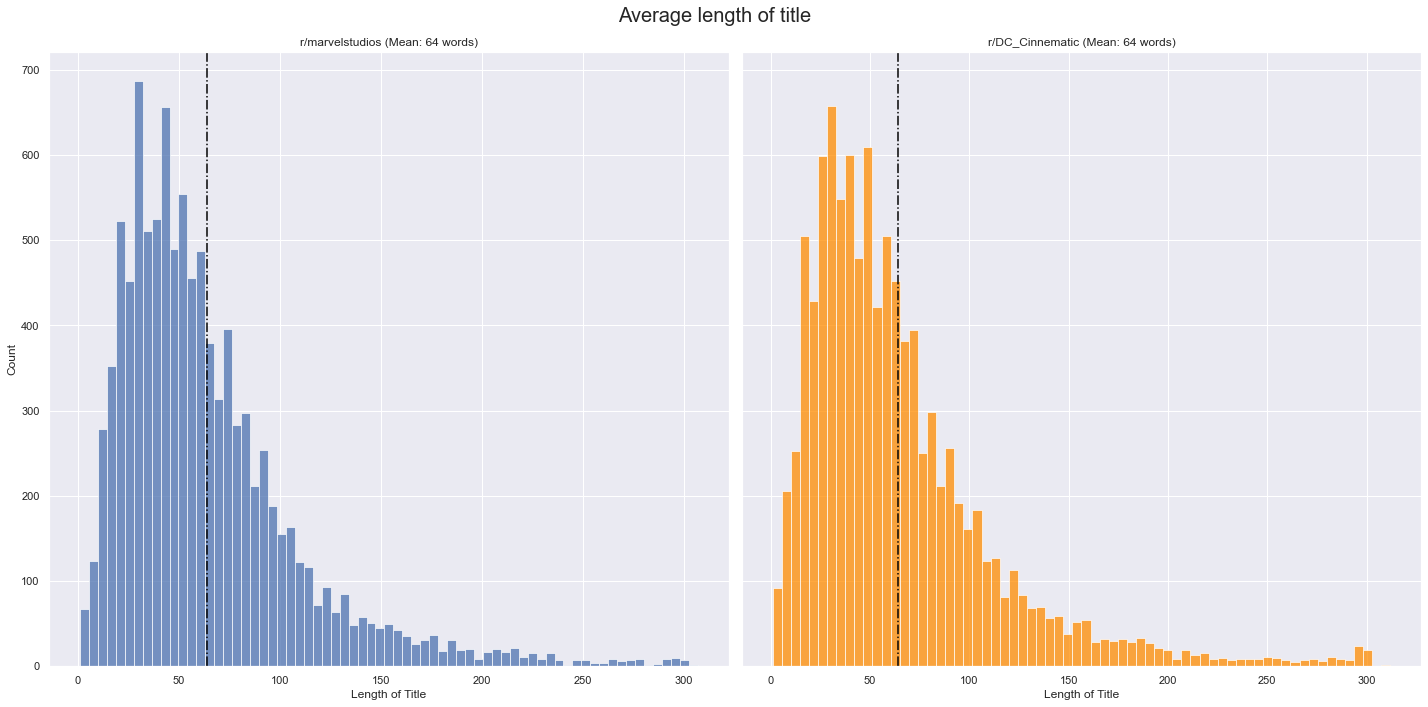

In [320]:
subplot_histograms(ms_df, dc_df, 'title', 'Average length of title')

### Checking the length of the selftext

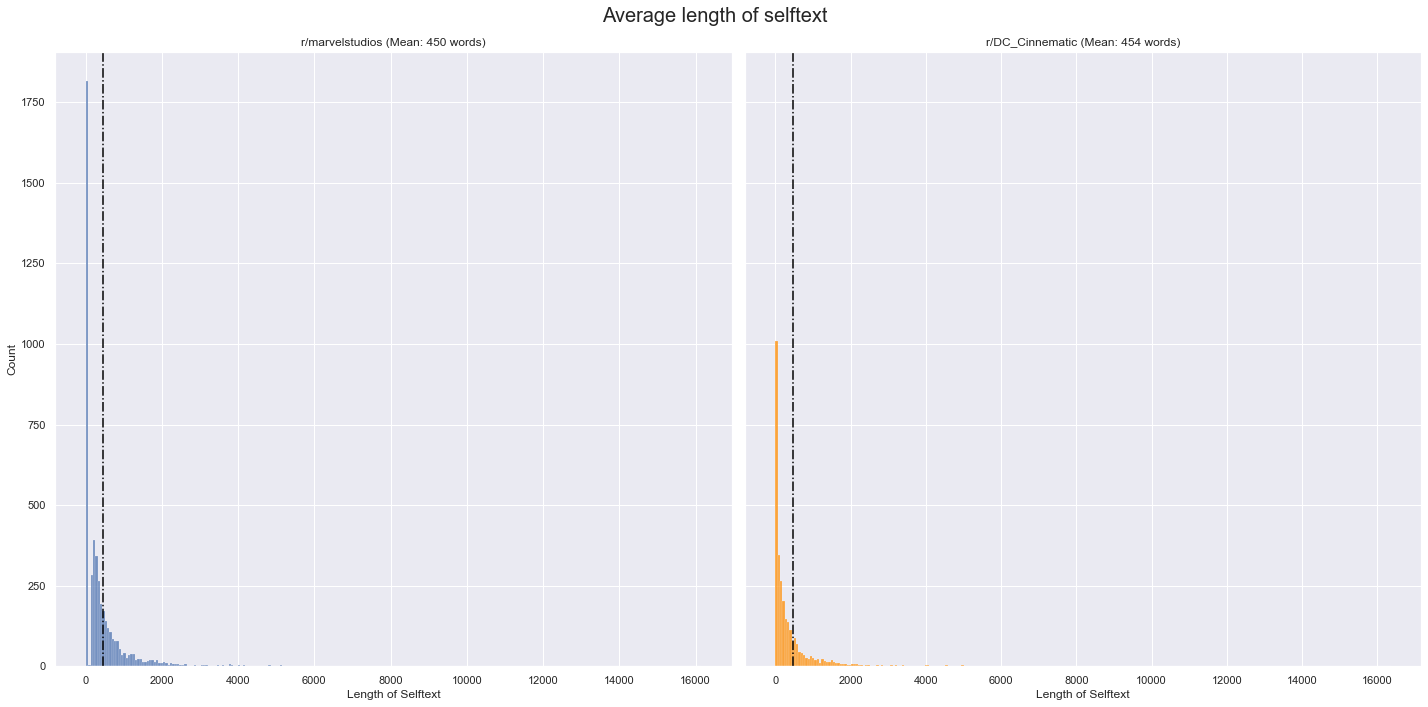

In [321]:
subplot_histograms(ms_df, dc_df, 'selftext', 'Average length of selftext')

From the preliminary EDA, average length of the title is 64 words for both subreddits. The average length of the self-text is 450 words and 454 words for the marvelstudios and the DC_Cinnematic subreddit respectively. 

Since the length of the selftext and the title is high, the removal of stop words are critical to reduce the size of the corpus in the data-set. This alongside non-alphabatic words, and emoji are removed and converted to code readable language respectively for future analysis. 

Use of the plot of the top 10 words for the countvectorizer, stemming and lemmatizer using uni-gram, bi-gram and tri-gram to include or remove stop words.

# Data Cleaning

In [322]:
# Function to get dataframe + preliminary cleaning
def get_df(df_full):
    # Returning following three columns 'subreddit', 'title', 'selftext'.
    df = df_full[['subreddit', 'title', 'selftext']]
    # Renaming 'selftext' column to 'body':
    df_c = df.copy()
    df_c.rename(columns = {'selftext': 'text'}, inplace = True)
    # View dataframe using info
    print(f" ")
    print(f"Dataframe prior to combining title and selftext")
    print(df_c.info())
    # Fill empty 'text' cells with 'title'
    df_c['text'].fillna(df_c['title'], inplace = True) 
    # Merge 'title' and 'text' of non-empty 'text' cells in new column
    df_c['post'] = df_c['title'] + " " + df_c['text']  
    df_c = df_c[['subreddit', 'post']]
    print(f" ")
    print(f"Dataframe after combining title and selftext")
    print(df_c.info())
    return df_c

In [323]:
ms = get_df(ms_df)
ms.head(5)

 
Dataframe prior to combining title and selftext
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10093 entries, 0 to 10092
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  10093 non-null  object
 1   title      10093 non-null  object
 2   text       4689 non-null   object
dtypes: object(3)
memory usage: 236.7+ KB
None
 
Dataframe after combining title and selftext
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10093 entries, 0 to 10092
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  10093 non-null  object
 1   post       10093 non-null  object
dtypes: object(2)
memory usage: 157.8+ KB
None


,subreddit,post
0,marvelstudios,"Unpopular Opinion: Who cares that the MCU is labeled 616, it’s really not a big deal. [removed]"
1,marvelstudios,"What's your favorite MCU Content Youtube Channel for Breakdowns, Easter Eggs, Theories, Reviews &amp; Reactions? [removed]"
2,marvelstudios,"I'd rather rewatch Thor 1 than Thor Ragnarok So some months ago I watched Thor 1 for the first time. It sucked. Left such a bad taste, I decided t..."
3,marvelstudios,"Venom is a Mimic Like, they both have the same design, they're both aliens. They can both (kind of) disguise themselves, and both turn people into..."
4,marvelstudios,Who do you guys think would win gwenpool or miles morales they are battling on the MCU endgame final battle spot Miles has all of his normal power...


In [324]:
dc = get_df(dc_df)
dc.head()

 
Dataframe prior to combining title and selftext
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10097 entries, 0 to 10096
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  10097 non-null  object
 1   title      10097 non-null  object
 2   text       2997 non-null   object
dtypes: object(3)
memory usage: 236.8+ KB
None
 
Dataframe after combining title and selftext
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10097 entries, 0 to 10096
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  10097 non-null  object
 1   post       10097 non-null  object
dtypes: object(2)
memory usage: 157.9+ KB
None


,subreddit,post
0,DC_Cinematic,Interesting Interesting
1,DC_Cinematic,My Justice League Lego set up at my apartment - (mostly done but may add things over time so open to suggestions) My Justice League Lego set up at...
2,DC_Cinematic,So turns out Ezra grooming or kidnapping allegations were false. So turns out Ezra grooming or kidnapping allegations were false.
3,DC_Cinematic,What was your reaction when it was announced who’d play Joker in DK all the way back in 2007? All the way back in 2007 when it was announced Heath...
4,DC_Cinematic,Zack Snyder is the Blueprint Zack Snyder is the Blueprint


From the above dataframe for both subreddit, both reddits has post which are very long sentences. Stop words are removed in the following cleaning to be narrowed down to reduce columns of the data during the modelling stage.

---

## Data dictonary 

The following is the data dictonary of the final input prior to pre-processing and modelling.

|Feature|Type|Dataset|Description|
|---|---|---|---|
|subreddit|object|DC_Cinematic/marvelstudios|Name of sub-reddit| 
|post|object|dictionary|Comment of the authour| 


# Tokenizing of corpus 

Tokenizing is a crutial step in pre-processing the data [source](https://towardsdatascience.com/tokenization-for-natural-language-processing-a179a891bad4) in classification model. Following NLTK tokenization method is used with stemming and lemmatization and paired with the EDA & visualization techniquess to address the problem statement identified.

In [325]:
# Define the function to see how many words were in the body before cleaning the data.
def word_count(series):
    # Change all the capital letters to snake case
    list_tokens = [w.lower() for w in series]
    string_tokens = str(list_tokens)
    tokens = BeautifulSoup(string_tokens).get_text()
    return tokens

In [326]:
len(word_count(ms['post']).split())

547899

In [327]:
len(word_count(dc['post']).split())

432857

From the above stages, stopwords and punctuations are common in the corpus of the data. Hence, removal of stop words and other insignificant words are conducted in the following section. De-emojizing of the post are done to further retain the information for further sentiment analysis.

## Removal of Stop words

In [328]:
# Determining the stopwords list
stop_words = stopwords.words('english')
extra_words = ['like', 'would', 'think', 'removed', 'movie', 'see', 'one' 'film', 
               'know', 'one', 'could', 'love', 'new', 'film', 'show', 'poll', 'https'
               ,'www', 'reddit', 'com', 'live', 'action', 'scene']
#excl_words = ['she', 'not']
stop_words.extend(extra_words)
stop_words.remove('she')
stop_words.remove('not')

### Use of lemmatizer on the dataframe

In [329]:
lemmatizer = WordNetLemmatizer()
def lemmatizer_words(status):
    '''takes a series and cleans the text data '''
    bw = []
    
    # De-emojizing of the   
    demoji_words =  emoji.demojize(status, delimiters=(":", ":"))
    
    # Removed Regex
    letters_only = re.sub('[^a-zA-Z]', ' ', demoji_words)
       
    # Removed Non-letters
    words = letters_only.lower().split()
    
    # Tokenize without official tokenizer
    stops = set(stop_words)
    
    # Remove Stopwords & lemmatizing
    meaningful_words = [lemmatizer.lemmatize(w) for w in words if w not in stops]
    return(' '.join(meaningful_words))

In [330]:
ms['post_clean_lemma'] = ms['post'].map(lemmatizer_words)
ms.head()

,subreddit,post,post_clean_lemma
0,marvelstudios,"Unpopular Opinion: Who cares that the MCU is labeled 616, it’s really not a big deal. [removed]",unpopular opinion care mcu labeled really not big deal
1,marvelstudios,"What's your favorite MCU Content Youtube Channel for Breakdowns, Easter Eggs, Theories, Reviews &amp; Reactions? [removed]",favorite mcu content youtube channel breakdown easter egg theory review amp reaction
2,marvelstudios,"I'd rather rewatch Thor 1 than Thor Ragnarok So some months ago I watched Thor 1 for the first time. It sucked. Left such a bad taste, I decided t...",rather rewatch thor thor ragnarok month ago watched thor first time sucked left bad taste decided skip thor thor second favourite norse god least ...
3,marvelstudios,"Venom is a Mimic Like, they both have the same design, they're both aliens. They can both (kind of) disguise themselves, and both turn people into...",venom mimic design alien kind disguise turn people humanoid monster yes mimic technically completely fake mcu multiverse people ability manipulate...
4,marvelstudios,Who do you guys think would win gwenpool or miles morales they are battling on the MCU endgame final battle spot Miles has all of his normal power...,guy win gwenpool mile morale battling mcu endgame final battle spot mile normal power including venom invisibility gwen power including going pane...


In [331]:
# Add a column to the DataFrame, lemmatizer
ms['post_clean_lemma'] = ms['post'].map(lemmatizer_words)
dc['post_clean_lemma'] = dc['post'].map(lemmatizer_words)

In [332]:
print('r/marvelstudios')
print(ms['post'][0])
print('\n After cleaning \n')
print(ms['post_clean_lemma'][0])
print()
print('r/DC_Cinnematic')
print(dc['post'][0])
print('\n After cleaning \n')
print(dc['post_clean_lemma'][0])

r/marvelstudios
Unpopular Opinion: Who cares that the MCU is labeled 616, it’s really not a big deal. [removed]

 After cleaning 

unpopular opinion care mcu labeled really not big deal

r/DC_Cinnematic
Interesting Interesting

 After cleaning 

interesting interesting


### Use of stemmer on the dataframe

In [333]:
def stemming_words(status):
    '''takes a series and cleans the text data '''
    # De-emojizing of the   
    demoji_words =  emoji.demojize(status, delimiters=(":", ":"))
    #print(demoji_words)
    
    # Removed Regex
    letters_only = re.sub('[^a-zA-Z]', ' ', demoji_words)
       
    # Removed Non-letters
    words = letters_only.lower().split()
    
    # Tokenize without official tokenizer
    stops = set(stop_words)
        
    # Remove Stopwords & lemmatizing / stemming
    stemmer = PorterStemmer()
    meaningful_words = [stemmer.stem(w) for w in words if w not in stops]
    return(' '.join(meaningful_words))

In [334]:
# Add a column to the DataFrame, Stemming
ms['post_clean_stem'] = ms['post'].map(stemming_words)
dc['post_clean_stem'] = dc['post'].map(stemming_words)

In [335]:
print('r/marvelstudios')
print(ms['post'][0])
print('\n After cleaning \n')
print(ms['post_clean_stem'][0])
print()
print('r/DC_Cinnematic')
print(dc['post'][0])
print('\n After cleaning \n')
print(dc['post_clean_stem'][0])

r/marvelstudios
Unpopular Opinion: Who cares that the MCU is labeled 616, it’s really not a big deal. [removed]

 After cleaning 

unpopular opinion care mcu label realli not big deal

r/DC_Cinnematic
Interesting Interesting

 After cleaning 

interest interest


In [237]:
ms.sample(25)

,subreddit,post,post_clean_lemma,post_clean_stem
3172,marvelstudios,Spiderman [removed],spiderman,spiderman
1761,marvelstudios,Why Has the MCU Been So Much Better Than Other Cinematic Universes? Title. So many other studios/ franchises have attempted to set up Cinematic Un...,mcu much better cinematic universe title many studio franchise attempted set cinematic universe trade mark seeing success marvel dceu shitty tom c...,mcu much better cinemat univers titl mani studio franchis attempt set cinemat univers trade mark see success marvel dceu shitti tom cruis monster ...
4900,marvelstudios,Age of Ultron: Scarlet Witch and Quicksilver Age of Ultron: Scarlet Witch and Quicksilver,age ultron scarlet witch quicksilver age ultron scarlet witch quicksilver,age ultron scarlet witch quicksilv age ultron scarlet witch quicksilv
10078,marvelstudios,Question About the Multiverse and the Variants [removed],question multiverse variant,question multivers variant
4868,marvelstudios,Do you think Vision will let people die to sustain Wanda? idk he seems to selfless to me for that to happen Do you think Vision will let people di...,vision let people die sustain wanda idk seems selfless happen vision let people die sustain wanda idk seems selfless happen,vision let peopl die sustain wanda idk seem selfless happen vision let peopl die sustain wanda idk seem selfless happen
4552,marvelstudios,"Sophia DiMartino has won ""Breakthrough Performance"" at the #MTVAwards for her portrayal as Sylvie in #Loki! Sophia DiMartino has won ""Breakthrough...",sophia dimartino breakthrough performance mtvawards portrayal sylvie loki sophia dimartino breakthrough performance mtvawards portrayal sylvie loki,sophia dimartino breakthrough perform mtvaward portray sylvi loki sophia dimartino breakthrough perform mtvaward portray sylvi loki
1007,marvelstudios,How do you feel about Early Screeners Sharing Reactions? Just saw a tweet from an MCU YouTuber going to see Love &amp; Thunder today &amp; while t...,feel early screener sharing reaction saw tweet mcu youtuber going amp thunder today amp people spoil anything really unfollow keep hearing seeing ...,feel earli screener share reaction saw tweet mcu youtub go amp thunder today amp peopl spoil anyth realli unfollow keep hear see reaction even thu...
7948,marvelstudios,"When is Doom coming ? I think there's a separate Doom fanbase and on behalf of it, I'm asking when will he be coming ? Also, I'd like him to come ...",doom coming separate doom fanbase behalf asking coming also come solo project not fantastic four movie others,doom come separ doom fanbas behalf ask come also come solo project not fantast four movi other
1220,marvelstudios,Marvel Studios helping out with Sony's Spidey Universe?! Marvel Studios helping out with Sony's Spidey Universe?!,marvel studio helping sony spidey universe marvel studio helping sony spidey universe,marvel studio help soni spidey univers marvel studio help soni spidey univers
2434,marvelstudios,"Why is Damage Control doing SHIELD stuff? It’s my one complaint since the fall of SHIELD, and having them go apparently super secret. There doesn’...",damage control shield stuff complaint since fall shield go apparently super secret seem consistency government agency supposed within mcu damage c...,damag control shield stuff complaint sinc fall shield go appar super secret seem consist govern agenc suppos within mcu damag control suppos aroun...


In [336]:
df_ms = ms[['post_clean_lemma','post_clean_stem']].apply(lambda x: x.str.strip()).replace('', np.nan)
# Expressing train columns in percentage of missing information.
df = df_ms .isnull().sum().sort_values(ascending=False)
per_1 = df_ms .isnull().sum() / len(df_ms)*100
# Casting series to a new dataframe
per_2 = (round(per_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([df,per_2], axis=1,keys=['number','percentage_null'])
missing_data

,number,percentage_null
post_clean_lemma,42,0.4
post_clean_stem,42,0.4


In [337]:
df_dc = dc[['post_clean_lemma','post_clean_stem']].apply(lambda x: x.str.strip()).replace('', np.nan)
# Expressing train columns in percentage of missing information.
df = df_dc .isnull().sum().sort_values(ascending=False)
per_1 = df_dc .isnull().sum() / len(df_dc)*100
# Casting series to a new dataframe
per_2 = (round(per_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([df,per_2], axis=1,keys=['number','percentage_null'])
missing_data

,number,percentage_null
post_clean_lemma,52,0.5
post_clean_stem,52,0.5


From the above dataframe, the post_clean_lemma and post_clean_stem will be output as a blank if the post was made in non-alphabetical letters. 
All the blanks is replaced with a null value and both the percentage null of the r/marvelstudios and r/DC_Cinnematic is 4% and 5% accordingly. Hence, the non-alphabetical rows would be dropped during the pre-processing stages and prior to the modelling step.

In summary there are 3 points for potential outliers:
1. Loss of information of post that is only images identified in the plot for type of post above. This is addressed by the combining the selftext and the title post.
2. Loss of information from emojis. This is resolved by converting the emoji to text using demojise
3. Loss of information from non-latin words. This is resolved by using regex to scrap such rows which is then dropped in the next codebook.

## Plot of highest number of words in the dataset

In [340]:
# Drop of the rows will null values.
ms[['post_clean_lemma','post_clean_stem']].apply(lambda x: x.str.strip()).replace('', np.nan)
ms.dropna(subset=['post_clean_lemma', 'post_clean_stem'],how ='all', inplace = True)

dc[['post_clean_lemma','post_clean_stem']].apply(lambda x: x.str.strip()).replace('', np.nan)
dc.dropna(subset=['post_clean_lemma', 'post_clean_stem'], how ='all', inplace = True);

In [387]:
ms.shape, dc.shape, df_ms.shape, df_dc.shape

((10093, 4), (10097, 4), (10051, 2), (10045, 2))

In [206]:
# Creating plots for the tokenizing for the eda
def plot_top_tokens(df, col, n, n_gram_range, title, palette='tab10'):
    def get_top_n_tokens(corpus, n=n, k=n_gram_range):     
        vec = CountVectorizer(ngram_range=(k,k), stop_words = stop_words).fit(corpus)     
        bag_of_words = vec.transform(corpus)     
        sum_words = bag_of_words.sum(axis=0)      
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]    
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True) 
        return words_freq[:n]
    
    temp_df = pd.DataFrame(data=get_top_n_tokens(df[col], n), columns=['word','freq'])
    plt.figure(figsize=(10,6))
    sns.barplot(data=temp_df, y='word', x='freq', palette=palette)
    plt.ylabel('')
    plt.xlabel('')
    plt.title(title, fontsize=18)

# EDA on post column

Both the uni-gram and the bi-gram indicates the top of the characters and heros to highlights that the top characters in both subreddits for marvel and dc. This are the top heros addressing the top heros for the problem statement.

## CountVectorizer: Uni-gram

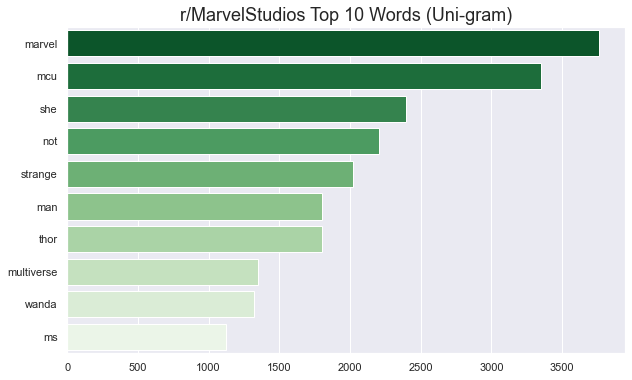

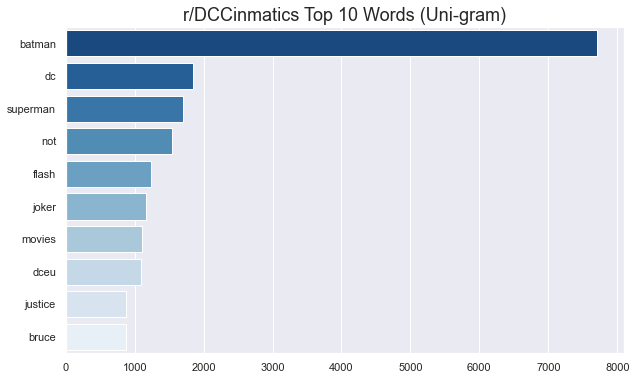

In [207]:
plot_top_tokens(ms, 'post', 10, 1, 'r/MarvelStudios Top 10 Words (Uni-gram)', 'Greens_r')
plot_top_tokens(dc,'post', 10, 1, 'r/DCCinmatics Top 10 Words (Uni-gram)', 'Blues_r')

## Countvectorizer: Bi-gram

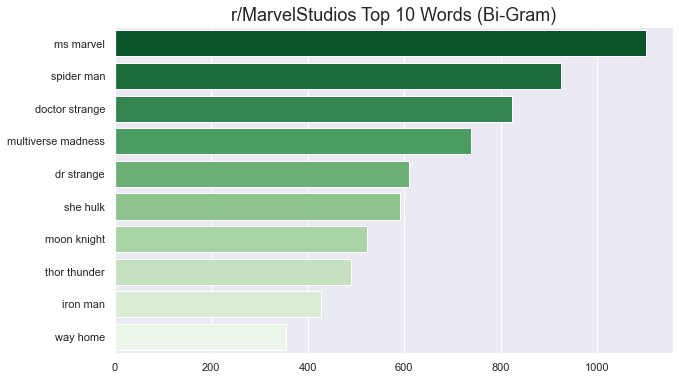

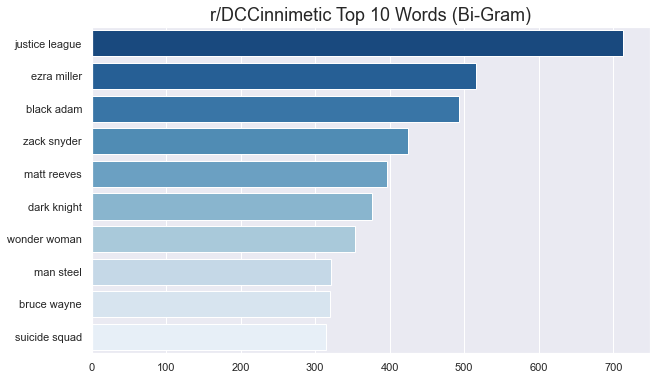

In [209]:
plot_top_tokens(ms,'post', 10, 2, 'r/MarvelStudios Top 10 Words (Bi-Gram)', 'Greens_r')
plot_top_tokens(dc,'post', 10, 2, 'r/DCCinnimetic Top 10 Words (Bi-Gram)', 'Blues_r')

## Countvectorizer: Tri-gram

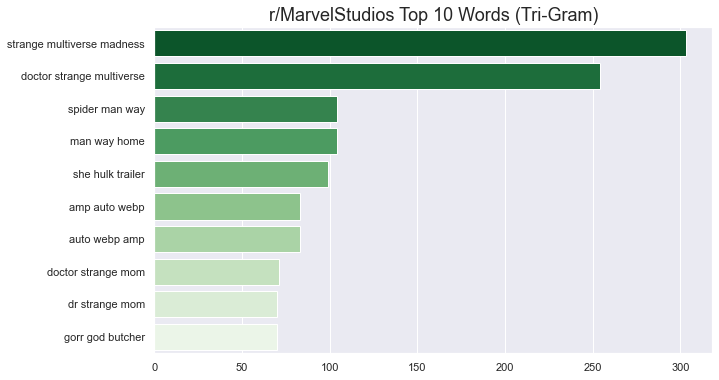

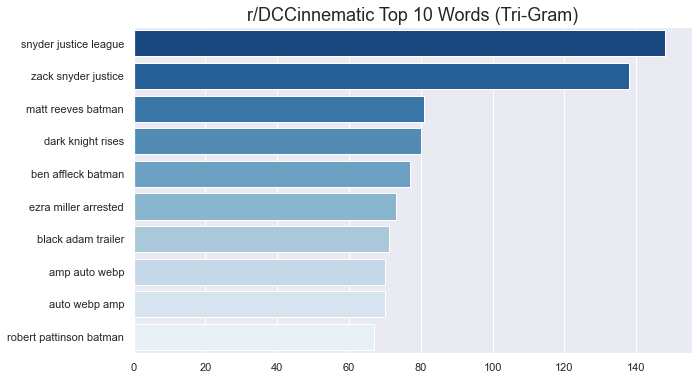

In [388]:
plot_top_tokens(ms,'post', 10, 3, 'r/MarvelStudios Top 10 Words (Tri-Gram)', 'Greens_r')
plot_top_tokens(dc,'post', 10, 3, 'r/DCCinnematic Top 10 Words (Tri-Gram)', 'Blues_r')

In [397]:
len(word_count(ms['post']).split()), len(word_count(dc['post']).split())

(547899, 432857)

# EDA on post_clean_lemma column

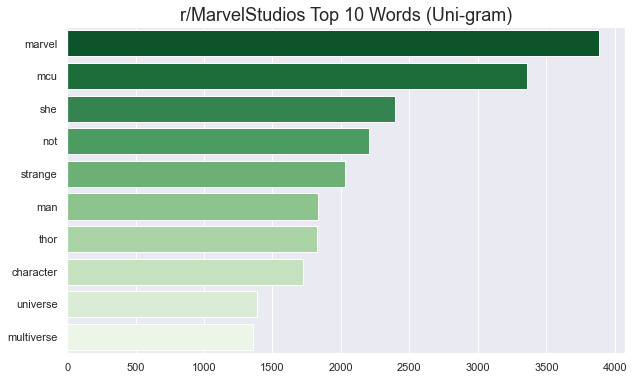

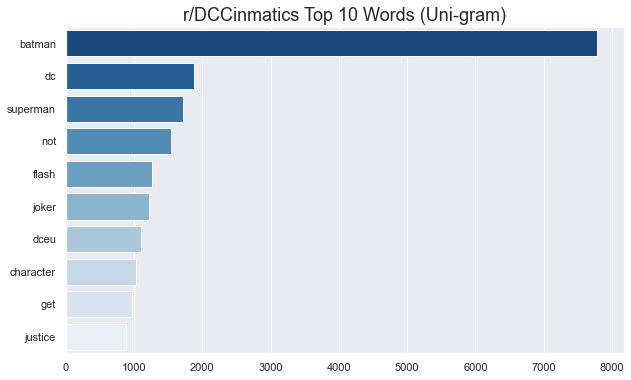

In [389]:
plot_top_tokens(df_ms, 'post_clean_lemma', 10, 1, 'r/MarvelStudios Top 10 Words (Uni-gram)', 'Greens_r')
plot_top_tokens(df_dc,'post_clean_lemma', 10, 1, 'r/DCCinmatics Top 10 Words (Uni-gram)', 'Blues_r')

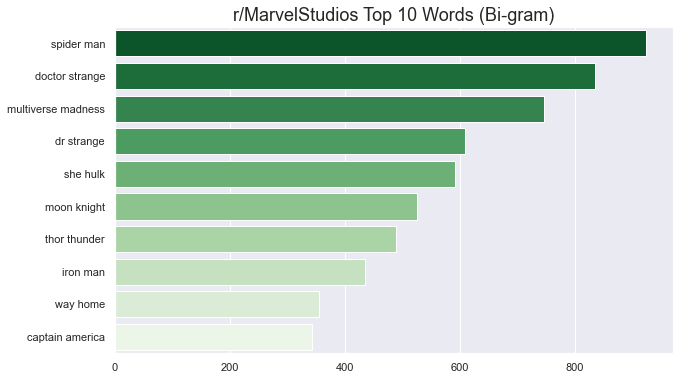

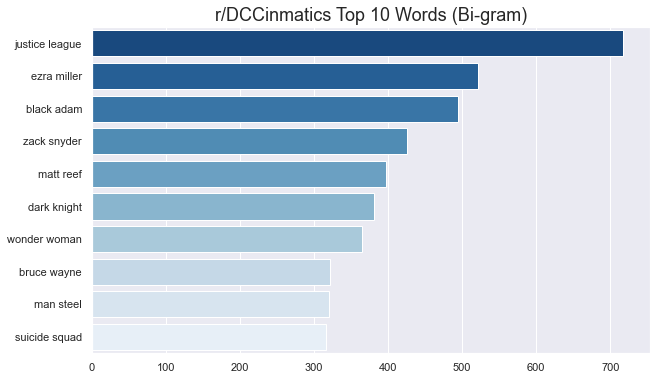

In [390]:
plot_top_tokens(df_ms, 'post_clean_lemma', 10, 2, 'r/MarvelStudios Top 10 Words (Bi-gram)', 'Greens_r')
plot_top_tokens(df_dc,'post_clean_lemma', 10, 2, 'r/DCCinmatics Top 10 Words (Bi-gram)', 'Blues_r')

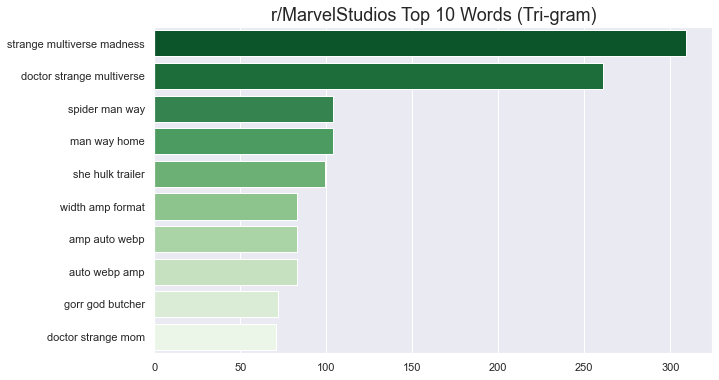

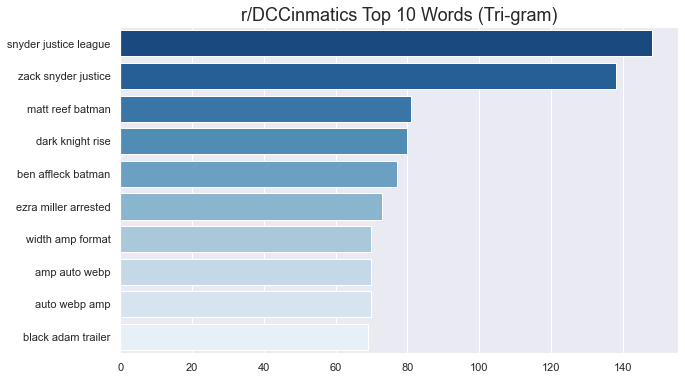

In [391]:
plot_top_tokens(df_ms, 'post_clean_lemma', 10, 3, 'r/MarvelStudios Top 10 Words (Tri-gram)', 'Greens_r')
plot_top_tokens(df_dc,'post_clean_lemma', 10, 3, 'r/DCCinmatics Top 10 Words (Tri-gram)', 'Blues_r')

### Print the no of features using post_clean_lemm

In [392]:
len(word_count(df_ms['post_clean_lemma']).split()), len(word_count(df_dc['post_clean_lemma']).split())

(284535, 229152)

# EDA on post_clean_stem column

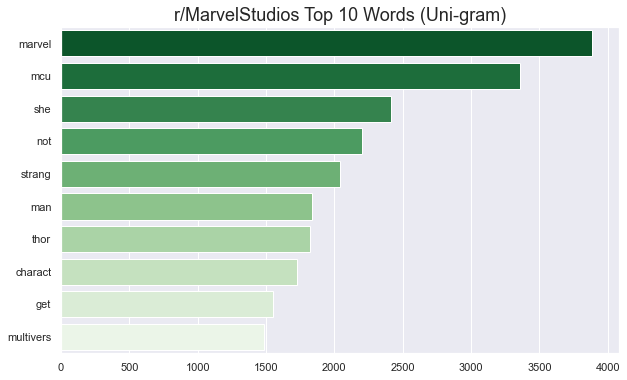

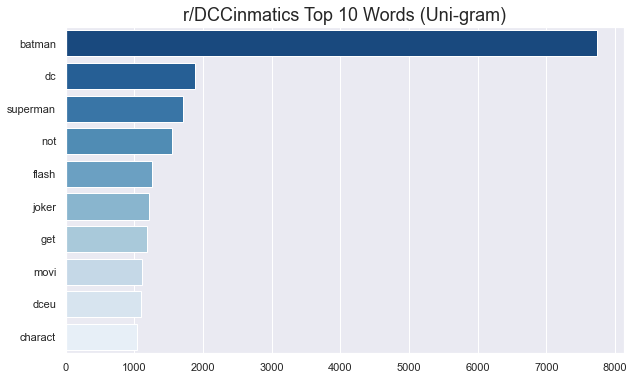

In [393]:
plot_top_tokens(df_ms, 'post_clean_stem', 10, 1, 'r/MarvelStudios Top 10 Words (Uni-gram)', 'Greens_r')
plot_top_tokens(df_dc,'post_clean_stem', 10, 1, 'r/DCCinmatics Top 10 Words (Uni-gram)', 'Blues_r')

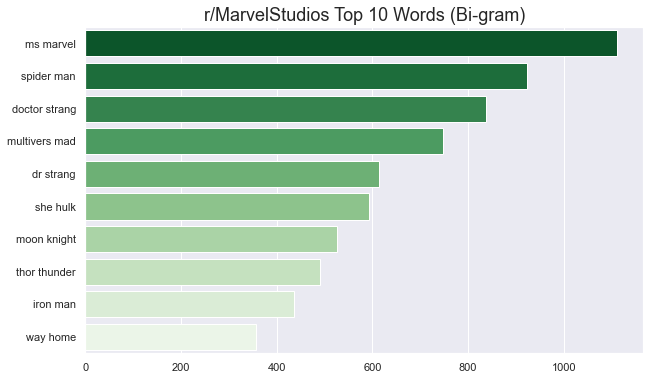

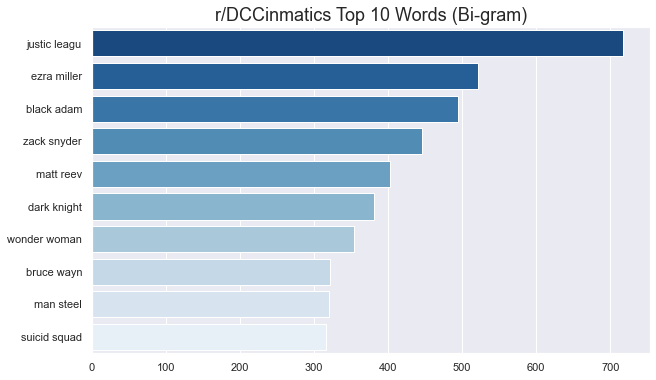

In [394]:
plot_top_tokens(df_ms, 'post_clean_stem', 10, 2, 'r/MarvelStudios Top 10 Words (Bi-gram)', 'Greens_r')
plot_top_tokens(df_dc,'post_clean_stem', 10, 2, 'r/DCCinmatics Top 10 Words (Bi-gram)', 'Blues_r')

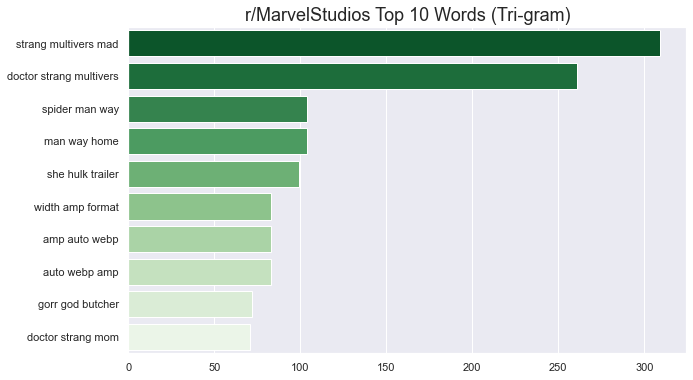

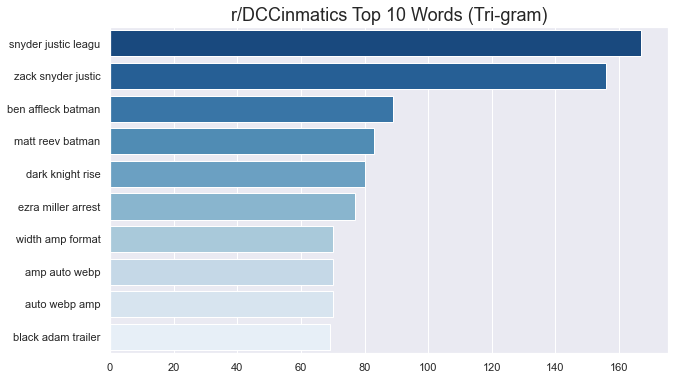

In [395]:
plot_top_tokens(df_ms, 'post_clean_stem', 10, 3, 'r/MarvelStudios Top 10 Words (Tri-gram)', 'Greens_r')
plot_top_tokens(df_dc,'post_clean_stem', 10, 3, 'r/DCCinmatics Top 10 Words (Tri-gram)', 'Blues_r')

In [396]:
len(word_count(df_ms['post_clean_stem']).split()), len(word_count(df_dc['post_clean_stem']).split())

(284535, 229152)

From the above bar charts, the top 10 words are the same for the all the 3 different types of tokenization. The no of features for the countvectorization for normal tokenized text is (547899, 432857) for marvelstudios and DC_Cinnematics. Both stemming and lemmatizing has (284535, 229152) distinct corpus and both tokenizer methods would be scored in subsequent code notebook.

# Exporting of dataframe for modelling

## Identification of target column

In [398]:
# Save and export cleaned data
ms.to_csv('./datasets/marvelstudios_clean.csv', index=None)
dc.to_csv('./datasets/dccinematic_clean.csv', index=None)

In [410]:
# Combine the 2 dataframes 
combined = pd.concat([ms, dc], axis=0)
combined.info()
combined.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20190 entries, 0 to 10096
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   subreddit         20190 non-null  object
 1   post              20190 non-null  object
 2   post_clean_lemma  20190 non-null  object
 3   post_clean_stem   20190 non-null  object
dtypes: object(4)
memory usage: 788.7+ KB


,subreddit,post,post_clean_lemma,post_clean_stem
10092,DC_Cinematic,BTS on The Batman featuring LED screens (same technique as Mandalorian) BTS on The Batman featuring LED screens (same technique as Mandalorian),bts batman featuring led screen technique mandalorian bts batman featuring led screen technique mandalorian,bt batman featur led screen techniqu mandalorian bt batman featur led screen techniqu mandalorian
10093,DC_Cinematic,"Is the Watchmen show worth watching? I finished the movie not long ago and loved it, especially Rorschach. Is the show as good as the movie, and d...",watchman worth watching finished not long ago loved especially rorschach good rorschach stuff remember airing heard sequel original story also hea...,watchmen worth watch finish not long ago love especi rorschach good rorschach stuff rememb air heard sequel origin stori also heard good garner lo...
10094,DC_Cinematic,"Batman superfan Neymar in the Batmobile at Paris exhibit, via Matt Reeves Batman superfan Neymar in the Batmobile at Paris exhibit, via Matt Reeves",batman superfan neymar batmobile paris exhibit via matt reef batman superfan neymar batmobile paris exhibit via matt reef,batman superfan neymar batmobil pari exhibit via matt reev batman superfan neymar batmobil pari exhibit via matt reev
10095,DC_Cinematic,What is your surprise predictions for the Batman movie What is your surprise predictions for the Batman movie,surprise prediction batman surprise prediction batman,surpris predict batman surpris predict batman
10096,DC_Cinematic,I love the meta verse presentation I love the meta verse presentation,meta verse presentation meta verse presentation,meta vers present meta vers present


In [411]:
# Change subreddit to 0 for Earbuds and 1 for Headphones and rename column to 'is_headphones'
combined['subreddit'] = combined['subreddit'].map({'DC_Cinematic': 0, 'marvelstudios': 1})
combined.rename(columns = {'subreddit': 'is_marvelstudios'}, inplace = True)
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20190 entries, 0 to 10096
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   is_marvelstudios  20190 non-null  int64 
 1   post              20190 non-null  object
 2   post_clean_lemma  20190 non-null  object
 3   post_clean_stem   20190 non-null  object
dtypes: int64(1), object(3)
memory usage: 788.7+ KB


In [412]:
combined.to_csv('./datasets/combined_clean.csv')